In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional

import dca
import evo_weight_tools

import dataloader

In [2]:
CODON_MAP = dataloader.codon_map
qc = len(CODON_MAP) # qc = 61


AA_MAP =  dataloader.AA_map_str.copy()
if '-' in AA_MAP:
    del AA_MAP['-']
qa = len(AA_MAP) # qa = 20
INV_AA_MAP = {v:k for k,v in AA_MAP.items()}


#CODON_AA_MAP
CODON_AA_MAP = np.array([AA_MAP[dataloader.codon_table.forward_table[c]] for 
                         c, idx in CODON_MAP.items()], dtype=np.int)
CODON_AA_MAP = torch.from_numpy(CODON_AA_MAP)

# Binary matrix that translates between Codon index and Amino Acid index
codon_aa_mat = torch.eye(len(AA_MAP))[CODON_AA_MAP].float() # shape (qc, qa) binary

In [3]:
def load_msa(filename):
    ret = evo_weight_tools.get_codon_msa_as_int_array(filename, dataloader.codon_map)
    return torch.ByteTensor(ret)

def load_log_proposal(filename):
    return torch.FloatTensor(np.load(filename))

def load_msa_and_log_proposal(round_num):
    msa_round = load_msa(f"./data_test/Round{round_num}_Q15_C10_nts.aln.gz")
    log_proposal_round = load_log_proposal(f"./data_test/Round{round_num}_weights.npy")
    return msa_round, log_proposal_round

In [4]:
# Load all the MSAs (pytorch ints) and evo weights (floats) 
# and concatenate them together
msa_proposal_zip = zip(*map(load_msa_and_log_proposal, [1,2]))
msa_int = torch.cat(next(msa_proposal_zip))
log_proposal = torch.cat(next(msa_proposal_zip))
del(msa_proposal_zip)
L = msa_int.shape[1]
print(f"Length of sequences: {L}")
print(f"MSA shape: {msa_int.shape}")
print(f"Log Proposal shape: {log_proposal.shape}")

Length of sequences: 186
MSA shape: torch.Size([19973, 186])
Log Proposal shape: torch.Size([19973, 186, 61])


In [5]:
# Reduce the number of Amino Acid positions for testing purposes
L = 20
log_proposal = log_proposal[:, :L, :]
msa_int = msa_int[:, :L]

In [6]:
# Reduce the number of data points for testing purposes
#N = 10
#log_proposal = log_proposal[:N, ...]
#msa_int = msa_int[:N, ...]

In [7]:
with torch.no_grad():
    msa_one_hot = torch.nn.functional.one_hot(msa_int.long(), qc).float()
    weights = torch.ones(msa_one_hot.shape[0], dtype=torch.float)
    msa_cat = msa_one_hot.argmax(dim=2) # should be the same as msa_int now

In [8]:
class EvoDCA(dca.DCA):
    
    def forward(self, x, x_log_proposal):
        """`x` is a one-hot encoded MSA (or subset of an MSA) Shape: (n, L, q)
           `x_log_proposal` is the weights computed by evo_weight_tools Shape: (n, L, q)
        """
        x_msa = x
        w_eye = self.w * self.weights_eye
        self.weights = w_eye + w_eye.permute(2,3,0,1)
        
        # convert weights and biases to codon level params
        weights_codon = self.weights.index_select(1, 
                                CODON_AA_MAP).index_select(3, CODON_AA_MAP)
        bias_codon = self.bias.index_select(1, CODON_AA_MAP)
        
        # calculate logits with codon params and add in log_proposal
        x_logit = torch.tensordot(x_msa, weights_codon, 2) + bias_codon + x_log_proposal
        return x_logit



In [9]:
pseudo_count = 0.01 

with torch.no_grad():
    b_ini = torch.matmul(msa_one_hot.float(), codon_aa_mat) + pseudo_count
    b_ini = torch.log(b_ini.mean(0))
    model = EvoDCA(ncol=L, 
                   ncat=qa, # Initialize DCA model with number of amino acids and not
                            # number of codons as that is the shape of our params
                   Neff=1,  # ??Not sure what we should set this to
                   b_ini = b_ini,
                   lam_w = 1.0, # increase the regularization as we have very little effective data
                   lam_b = 1.0)


In [10]:
learning_rate = 1e-3
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train() # sets model to TRAIN mode

EvoDCA()

In [11]:
losses = np.zeros(num_epochs, dtype=np.double)

loss_fn = EvoDCA.create_loss_function()
for epoch in range(num_epochs):
    x_logit = model(msa_one_hot, log_proposal)
    loss = loss_fn(x_logit=x_logit, x_cat=msa_cat, 
                   x_weights=weights, model=model, verbose=False)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses[epoch] = loss.item()
    print(f"Epoch {epoch}, loss: {loss:.4f}")


Epoch 0, loss: 70225.4062
Epoch 1, loss: 70140.2656
Epoch 2, loss: 69964.2578
Epoch 3, loss: 69855.1406
Epoch 4, loss: 69766.2109
Epoch 5, loss: 69659.9375
Epoch 6, loss: 69553.7969
Epoch 7, loss: 69466.6250
Epoch 8, loss: 69400.9922
Epoch 9, loss: 69345.1953
Epoch 10, loss: 69288.9688
Epoch 11, loss: 69233.7266
Epoch 12, loss: 69186.1719
Epoch 13, loss: 69150.1719
Epoch 14, loss: 69124.1094
Epoch 15, loss: 69101.6094
Epoch 16, loss: 69078.9219
Epoch 17, loss: 69057.0781
Epoch 18, loss: 69038.4141
Epoch 19, loss: 69024.7031
Epoch 20, loss: 69014.6719
Epoch 21, loss: 69004.9297
Epoch 22, loss: 68993.8594
Epoch 23, loss: 68981.8828
Epoch 24, loss: 68970.8203
Epoch 25, loss: 68961.6172
Epoch 26, loss: 68953.5391
Epoch 27, loss: 68945.0312
Epoch 28, loss: 68935.4766
Epoch 29, loss: 68925.4766
Epoch 30, loss: 68916.0156
Epoch 31, loss: 68908.0625
Epoch 32, loss: 68900.7734
Epoch 33, loss: 68893.1328
Epoch 34, loss: 68885.1016
Epoch 35, loss: 68877.4531
Epoch 36, loss: 68870.7344
Epoch 37, l

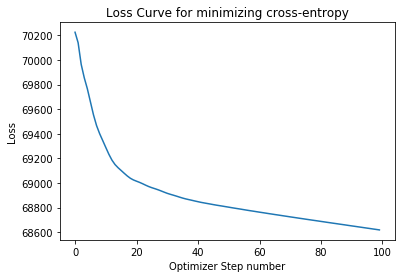

In [12]:
plt.plot(losses)
plt.title("Loss Curve for minimizing cross-entropy")
plt.xlabel("Optimizer Step number")
plt.ylabel("Loss");